## PyTorchの使い方
カーネルは、Python3を使用します。


### 準備

In [0]:
# python用のライブラリ
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
import torch
from torch import nn

param = sns.set()

## 演算

行列ベクトル計算でよく使うものは以下の通りです。

| 演算子 | 説明 |
|---|---|
| dot | ベクトルの内積 |
| mv | 行列とベクトルの積 |
| mm | 行列と行列の積 |

In [2]:
m = torch.tensor([[1,2], [3, 4], [5, 6]])   # R^{3 x 2}の行列mを生成
v = torch.tensor([1, 2])                    # R^2 のベクトルを生成
print(m)
print(v)

# 内積
d = torch.dot(v, v)
print(type(d))
print(d)

# 行列・ベクトルの積
mv = torch.mv(m, v)
print(mv)

tensor([[1, 2],
        [3, 4],
        [5, 6]])
tensor([1, 2])
<class 'torch.Tensor'>
tensor(5)
tensor([ 5, 11, 17])


## 自動微分

ニューラルネットでは、目的の関数の値が小さくなるように、目的関数の勾配（変数で微分した値）を求めて、少しずつ変数の値を更新していきます。

そのため、自動微分はニューラルネット関連のツールでは必須機能となっています。

In [3]:
# 求める変数
kernel = torch.tensor([2.0],requires_grad=True)
bias = torch.tensor([1.0], requires_grad=True)
# 観測された値
y = torch.Tensor([2])
x = torch.Tensor([3])
# 予想される値
y_pred = kernel * x + bias

# 観測値と予想値の２乗平均を損失関数とする
loss = torch.mean((y - y_pred)**2)
# 勾配を計算
loss.backward()
print(kernel.grad, bias.grad)

tensor([30.]) tensor([10.])


何が行われいるのか順を追ってみましょう。

kernel, biasを微分対象の変数だとわかるようにrequires_grad=Trueを付けます。

観測値x, yから　xとyの間に以下の関係があると仮定します。
$$
y = kernel \, x + bias
$$

損失関数lossは、観測値と予想値の差の２乗を平均したものとします。
ここではxとyのデータ１個なので、平均と言っても値そのものになります。

$$
loss = (2 - kernel \times 3 - bias)^2
$$

lossの微分には、置換関数f(h(x))の微分が次のようになることを利用します。
$$
\frac{d f}{d x} = \frac{d f}{d h} \frac{d h}{d x}
$$

最初にlossを変数kernelで偏微分します。
$$
\frac{\partial loss}{\partial kernel} = \frac{\partial loss}{\partial (2 - kernel \times 3 - bias)} \frac{\partial (2 - kernel \times 3 - bias)}{\partial kernel} = 2\times(2 - 2\times3 - 1) \times -3 = 30
$$

同様にlossを変数biasで偏微分します。
$$
\frac{\partial loss}{\partial bias} = \frac{\partial loss}{\partial (2 - kernel \times 3 - bias)} \frac{\partial (2 - kernel \times 3 - bias)}{\partial bias} = 2\times(2 - 2\times3 - 1)  \times -1 = 10
$$

となり、kernel.gra, bias.gradの結果と一致します。



## PyTorchを使った回帰分析
"Deep Learning with JavaScript Neural Networks in TensorFlow.js"の２章にでてくるファイル転送時間とファイルサイズの関係式を求める回帰分析の例をPyTorchを使って求めてみましょう。

まずは、データを定義し、その素性を可視化してみましょう。


In [0]:
trainData = {
    'sizeMB': [0.080, 9.000, 0.001, 0.100, 8.000, 5.000, 0.100, 6.000, 0.050, 0.500, 
              0.002, 2.000, 0.005, 10.00, 0.010, 7.000, 6.000, 5.000, 1.000, 1.000],
    'timeMB': [0.135, 0.739, 0.067, 0.126, 0.646, 0.435, 0.069, 0.497, 0.068, 0.116,
              0.070, 0.289, 0.076, 0.744, 0.083, 0.560, 0.480, 0.399, 0.153, 0.149]
}
testData = {
    'sizeMB': [5.000, 0.200, 0.001, 9.000, 0.002, 0.020, 0.008, 4.000, 0.001, 1.000,
               0.005, 0.080, 0.800, 0.200, 0.050, 7.000, 0.005, 0.002, 8.000, 0.008],
    'timeMB': [0.425, 0.098, 0.052, 0.686, 0.066, 0.078, 0.070, 0.375, 0.058, 0.136,
               0.052, 0.063, 0.183, 0.087, 0.066, 0.558, 0.066, 0.068, 0.610, 0.057]
}
trainDf = pd.DataFrame(trainData)
trainDf['type'] = 'train'
testDf = pd.DataFrame(testData)
testDf['type'] = 'test'
df = trainDf.append(testDf) 

データは直線上にあるように見え、正の相関があることがわかります。

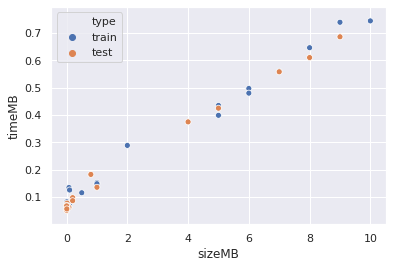

In [5]:
sns.scatterplot(x='sizeMB', y='timeMB', hue='type', data=df)
plt.show()

### モデルの定義
求めたいモデルを定義します。

$$
kernel \times sizeMB + bias
$$

In [0]:
def model(sizeMB, kernel, bias):
    return kernel * sizeMB + bias

入力(sizeMB)と出力(timeSec)をPyTorchのテンソルにします。

求めたい変数kernel, biasには、初期値として１と0をセットし、requires_grad=Trueで微分対象変数とします。

In [0]:
# 入力と出力テンソル
sizeMB = torch.Tensor(trainData['sizeMB'])
timeSec = torch.Tensor(trainData['timeMB'])

# カーネルとバイアス
kernel = torch.ones(1, requires_grad=True)
bias = torch.zeros(1, requires_grad=True)

### PyTorchでの変数の学習
kernelとbiasの値は、学習率(lr)で更新されます。

以下の例では100回の更新処理を行います。
損失関数の値の変化とkernel, biasの更新状況をみるため、losses, kernels, biases配列に計算結果を保持します。

In [0]:
# 損失関数の結果ログ
losses = []
kernels = []
biases = []
# 学習率
lr = 0.01

for i in range(100):
  kernel.grad = None
  bias.grad = None

  predict = model(sizeMB, kernel, bias)
  loss = torch.mean((timeSec - predict)**2)
  loss.backward()
  if i%20 == 0:
    kernels.append(kernel.item())
    biases.append(bias.item())
  losses.append(loss.item())
  with torch.no_grad():
    kernel -= lr * kernel.grad
    bias   -= lr * bias.grad

損失関数の値は、17.83から急速に0.014に近づいているのが、以下のグラフでもみて取れます。

In [12]:
# 損失関数の最初の５個を取り出す
losses[:5]

[17.83876609802246,
 5.787993431091309,
 1.8898894786834717,
 0.6287034749984741,
 0.22041241824626923]

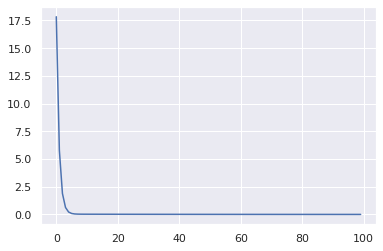

In [13]:
plt.plot(losses)
plt.show()

kernelとbiasの結果は、0.079, 0.014となりました。


In [14]:
print(kernel.item(), bias.item())

0.07920325547456741 0.014077912084758282


求まったkernel, biasの直線をデータに重ね合わせてみます。
１００回程度の繰り返しで、結構よい値が求まることが分かります。

In [15]:
x = torch.arange(0, 10, 0.01)
y = model(x, kernel, bias)
print(x[:5])
print(y[:5])

tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400])
tensor([0.0141, 0.0149, 0.0157, 0.0165, 0.0172], grad_fn=<SliceBackward>)


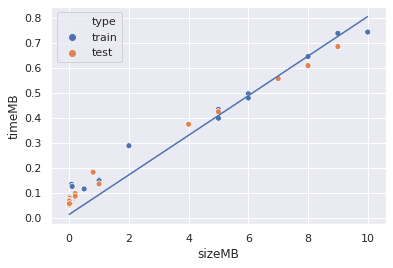

In [16]:
ax = sns.lineplot(x=x.detach().numpy(), y=y.detach().numpy())
sns.scatterplot(x='sizeMB', y='timeMB', hue='type', data=df, ax=ax)
plt.show()

### 損失関数の形とkernel, biasの変化
kernel, biasを値を変えて損失関数の変化をコンター図にプロットしてみましょう。

In [0]:
# 損失関数のコンター
N=20
X = np.linspace(-0.05, 0.15, N)
Y = np.linspace(-0.1, 0.15, N)

def f(x, y):
  kernel = torch.Tensor([x])
  bias = torch.Tensor([y])
  predict = model(sizeMB, kernel, bias)
  return torch.mean((timeSec - predict)**2)

# kernal, biasの値によって損失関数の値を計算
Z = [[f(X[j], Y[i]).numpy() for j in range(N)] for i in range(N)]


0回、20回、40回、60回、80回のkernel, biasをプロットすると、初期値(1,0)から（0.94, -0.89)、(0.089, -0.054)、(0.085, -0.026)、(0.081, -0.0039)と変わっています。

In [19]:
print(list(zip(kernels, biases)))


[(1.0, 0.0), (0.09452224522829056, -0.08938773721456528), (0.08933795243501663, -0.054424118250608444), (0.08519136905670166, -0.02639669179916382), (0.08186755329370499, -0.003930503502488136)]


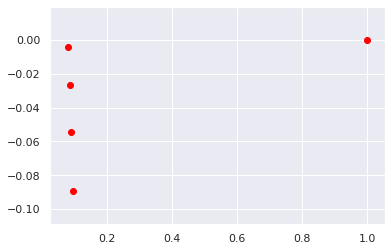

In [20]:
plt.scatter(kernels, biases, color='red')
plt.show()

これをコンター図に重ね合わせると、コンター図のもっとも低い位置（x）に赤丸が近づいているのが分かります。

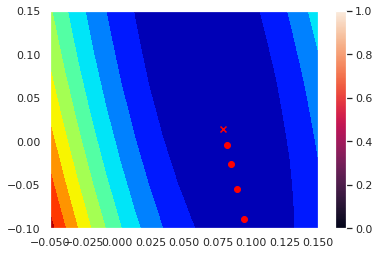

In [21]:
# コンター図を描画
Xs, Ys = np.meshgrid(X, Y)

fig, ax = plt.subplots()
plt.contourf(Xs, Ys, Z, levels=10, cmap='jet')
plt.scatter(kernels[1:], biases[1:], marker='o', color='red')
plt.scatter(kernel.item(), bias.item(), marker='x', color='red')
plt.colorbar();
plt.show()

## オプティマイザーを使った更新
PyTorchでは最適に変数を更新してくれるオプティマイザーが提供されています。
オプティマイザーと合わせて損失関数も用意されています。

先ほどの例をオプティマイザーを使って計算してみましょう。
今回は少し多めに1000回の更新処理します。


In [0]:
from torch import nn, optim

# カーネルとバイアス
kernel = torch.ones(1, requires_grad=True)
bias = torch.zeros(1, requires_grad=True)
# 損失関数として平均二乗誤差 (mean-squared error) を使用
loss_fn = nn.MSELoss()
#loss_fn = nn.L1Loss()

In [0]:
# オプティマイザーとして最も簡単な確率的勾配法（Stochastic Gradient Descent）を使用
optimizer = optim.SGD((kernel, bias), lr=0.01)

In [0]:
# 損失関数の結果ログ
losses = []

for i in range(1000):
  optimizer.zero_grad()                 # 勾配をゼロクリア
  predict = model(sizeMB, kernel, bias) # 予測値を求める
  loss = loss_fn(timeSec, predict)      # 損失値を求める
  loss.backward()                       # 損失関数の勾配を求める
  optimizer.step()                      # オプティマイザーで変数を更新
  losses.append(loss.item())

計算結果は、kernel=0.0684、bias=0.0868となりました。

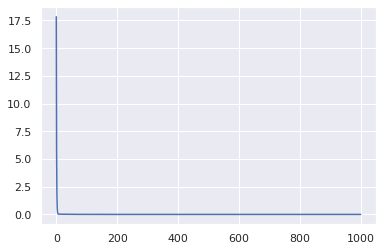

In [25]:
plt.plot(losses)
plt.show()

In [26]:
print(kernel, bias)

tensor([0.0684], requires_grad=True) tensor([0.0868], requires_grad=True)


## 最小二乗法との比較
先ほどの転送時間と転送量の関係を最小二乗法で求めてみましょう。

回帰直線の関係式は、以下のようになります。
$$
Y = A X
$$
この時、Xを求めるにはAの逆行列を使用します。
$$
X = A^{-1} Y
$$

AのSVD分解の結果U, S, Vを使って、
$$
A = U S V^T
$$
Aの疑似逆列は以下のように求まります。
$$
A^{-1} = V S^{-1} U^T
$$

### データーの加工
観測されたデータをマトリック表現に変換します。

$$
\left(
    \begin{array}{c}
      y_1  \\
      y_2  \\
      :  \\
      y_{20}
    \end{array}
  \right) = \left[
    \begin{array}{cc}
      x_1 & 1 \\
      x_2 & 1 \\
      :  \\
      x_{20} & 1
    \end{array}
  \right] \left(
    \begin{array}{c}
      kernel \\
      bias
    \end{array}
  \right)
$$

リストで表現されたxから列行列にするために、torch.stackを利用します。

In [27]:
a = torch.tensor([1,2,3])
b = torch.tensor([4,5,6])
torch.stack([a, b], dim=1)

tensor([[1, 4],
        [2, 5],
        [3, 6]])

転送時間と転送量の例では、xがsizeMB、yがtimeSecに相当します。

最初にマトリックスAを作ります。

In [0]:
A = torch.stack([sizeMB, torch.ones(20)], dim=1)

PyTorchで提供されているsvd関数を使ってマトリックスAをSVD分解をします。

先の一般逆行列を求めて、timeSecと行列・ベクトル積を行い、kenel, biasを求めてます。

In [0]:
(U, S, V) = torch.svd(A)

In [30]:
A_inv = torch.mm(torch.mm(V.t(), torch.diag(1/S)), U.t())
print(A_inv)

tensor([[-0.0125,  0.0251, -0.0128, -0.0124,  0.0209,  0.0083, -0.0124,  0.0125,
         -0.0126, -0.0107, -0.0128, -0.0044, -0.0128,  0.0293, -0.0128,  0.0167,
          0.0125,  0.0083, -0.0086, -0.0086],
        [ 0.0880, -0.0264,  0.0890,  0.0877, -0.0136,  0.0249,  0.0877,  0.0121,
          0.0884,  0.0826,  0.0890,  0.0634,  0.0890, -0.0393,  0.0889, -0.0008,
          0.0121,  0.0249,  0.0762,  0.0762]])


In [31]:
torch.mv(A_inv, timeSec)

tensor([0.0684, 0.0868])